In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h()
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [2]:
# import sys, os
# print(sys.executable)
# # remove environment vars that can inject conflicting pip flags for this session
# for k in list(os.environ):
#     if k.startswith("PIP") or k in ("PYTHONUSERBASE","PYTHONPATH"):
#         os.environ.pop(k, None)
# !{sys.executable} -m pip install --upgrade pip setuptools wheel build
# !{sys.executable} -m pip config list --local --global --site
# !{sys.executable} -m pip install --no-build-isolation cudaq -v

In [3]:
# import sys
# sys.path.insert(0, "/hpc/group/mcadoolab/ak699/.local_pkgs")  # <-- shared packages first
# import numpy as np
# import scipy
# import matplotlib.pyplot as plt

# import itertools
# from scipy.linalg import eigh
# from collections import defaultdict
# import math
# import re
# import os
# import glob
# from functools import reduce
# from IPython.display import display
# import pandas as pd

# try:
#     import scienceplots
#     plt.style.use(['science', 'no-latex', 'bright'])  # Use 'no-latex' for speed
# except ImportError:
#     plt.style.use('default')
#     print("SciencePlots style not found. Using default matplotlib style.")

In [4]:
!pip install cudaq

In [1]:
import sys

#sys.path.insert(0, "iQuHack 2026")
#sys.path.insert(0, "/hpc/group/mcadoolab/ak699/.local_pkgs/site")

import cudaq
#import auxiliary_files.labs_utils as utils

In [2]:
import numpy as np
from math import floor

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar.

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift.

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag.

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as.

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns.
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



<div style="background-color: #121212; border-left: 6px solid #76b900; padding: 18px; border-radius: 4px; color: #ffffff; font-family: Georgia, 'Times New Roman', serif;">

<h3 style="color: #76b900; margin-top: 0;"> Solution to Exercise 1: Symmetries of the LABS Problem</h3>

<p>
The low autocorrelation binary sequence (LABS) problem possesses intrinsic symmetries that generate multiple distinct bitstrings with identical energy values. These symmetries induce a nontrivial equivalence relation on the configuration space and significantly reduce the effective search domain.
</p>

<p>
Let $s = (s_1, \dots, s_N) \in \{\pm 1\}^N$. As given above, the LABS energy depends on autocorrelation terms of the form
</p>

$$
C_k(s) = \sum_{i=1}^{N-k} s_i s_{i+k}, \quad k = 1, \dots, N-1,
$$

<p>
and the total energy is a function only of these correlations. Two fundamental symmetry operations preserve all autocorrelation values and therefore leave the energy invariant.
</p>

<p>
The first is the <em>global bit-flip</em> symmetry,
</p>

$$
(s_1, \dots, s_N) \mapsto (-s_1, \dots, -s_N).
$$

<p>
Since each autocorrelation term involves products $s_i s_{i+k}$, the global sign cancels and all $C_k$ remain unchanged.
</p>

<p>
The second is the <em>bit-reversal</em> symmetry,
</p>

$$
(s_1, \dots, s_N) \mapsto (s_N, \dots, s_1).
$$

<p>
Autocorrelations depend only on relative index separations and not on their absolute ordering, so reversal leaves every $C_k$ invariant.
</p>

<p>
These two symmetries commute and together generate an equivalence class of four configurations for a generic bitstring. As a concrete illustration, consider $N = 7$ (which we play with in the widget provided above) and the sequence
</p>

$$
s = (+1, -1, +1, -1, +1, -1, +1).
$$

<p>
The four configurations obtained by the action of the symmetry group are listed below; each yields the same energy value $E = 91$:
</p>

<table style="width:100%; border-collapse: collapse; margin-top: 10px; background-color:#1c1c1c;">
<thead>
<tr>
<th style="border-bottom: 2px solid #76b900; padding: 8px; text-align:left; color:#ffffff;">Transformation</th>
<th style="border-bottom: 2px solid #76b900; padding: 8px; text-align:left; color:#ffffff;">Sequence</th>
<th style="border-bottom: 2px solid #76b900; padding: 8px; text-align:left; color:#ffffff;">Energy</th>
</tr>
</thead>
<tbody>
<tr>
<td style="border-bottom: 1px solid #333; padding: 8px;">Original</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$[+1, -1, +1, -1, +1, -1, +1]$</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$91$</td>
</tr>
<tr>
<td style="border-bottom: 1px solid #333; padding: 8px;">Global bit-flip</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$[-1, +1, -1, +1, -1, +1, -1]$</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$91$</td>
</tr>
<tr>
<td style="border-bottom: 1px solid #333; padding: 8px;">Bit reversal</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$[+1, -1, +1, -1, +1, -1, +1]$</td>
<td style="border-bottom: 1px solid #333; padding: 8px;">$91$</td>
</tr>
<tr>
<td style="padding: 8px;">Bit-flip and reversal</td>
<td style="padding: 8px;">$[-1, +1, -1, +1, -1, +1, -1]$</td>
<td style="padding: 8px;">$91$</td>
</tr>
</tbody>
</table>

<p>
Hence, apart from special palindromic or self-dual cases, each equivalence class contains four energetically identical configurations. It follows that the number of distinct energy configurations scales as $2^{N-2}$ rather than $2^N$. Leveraging these symmetries seems therefore to be essential for both theoretical analysis and efficient algorithmic approaches to the LABS problem. Hopefully, we will exploit this dimensionality reduction of the configuration space later in the tutorial. LESGOOOOOO!!!
</p>

</div>


<div style="background-color: #121212; border-left: 6px solid #76b900; padding: 18px; border-radius: 4px; color: #ffffff; font-family: 'Times New Roman', Georgia, serif;">

<h3 style="color: #76b900; margin-top: 0;"> Solution to Exercise&nbsp;2: Classical Memetic Tabu Search for LABS</h3>

<p style="font-size: 15px; margin: 0 0 10px 0;">
We implement a classical <em>Memetic Tabu Search</em> (MTS) algorithm to solve the low-autocorrelation binary sequence (LABS) problem as a preparatory step before introducing any quantum-enhanced techniques. The objective is to minimize the LABS energy
$$
E(s)=\sum_{k=1}^{N-1} C_k(s)^2, \qquad C_k(s)=\sum_{i=1}^{N-k} s_i s_{i+k},
$$
over sequences $s=(s_1,\dots,s_N)\in\{\pm1\}^N$, following the algorithmic structure described in the referenced literature.
</p>

<p style="font-size: 15px; margin: 0 0 10px 0;">
The MTS procedure maintains a population of $K$ candidate sequences and evolves this population through a memetic loop combining global exploration with intensive local improvement. In each generation, a child sequence is generated either by single-point crossover between two parents or by direct resampling from the population. The crossover operator selects a cut index uniformly at random and concatenates the prefix of the first parent with the suffix of the second. The child is then subjected to stochastic mutation, where each bit is flipped independently with probability $p_{\mathrm{mut}}=1/N$.
</p>

<p style="font-size: 15px; margin: 0 0 10px 0;">
Local refinement of each child is performed via a tabu search operating on the single-bit-flip neighborhood. The tabu mechanism employs a short-term memory structure with randomized tenure to prevent cycling, while an aspiration criterion permits tabu moves whenever they yield a new global best solution. The number of tabu iterations is itself randomized within a range proportional to the sequence length, introducing controlled stochasticity while preserving strong intensification toward local minima.
</p>

<p style="font-size: 15px; margin: 0 0 10px 0;">
After local improvement, the resulting child replaces a randomly selected individual in the population, and the global incumbent best sequence is updated whenever a lower energy configuration is discovered. This replacement strategy preserves population diversity while steadily biasing the search toward lower-energy regions of the landscape. The algorithm terminates after a fixed number of generations or upon reaching a known optimal energy value when available.
</p>

<p style="font-size: 15px; margin: 0 0 10px 0;">
To validate the implementation, we verify correctness on small sequence lengths by confirming that the returned solution is a strict local minimum under all single-bit flips. These exact solutions are reported in Packebush and Mertens (2016). We then benchmark performance against known optimal energies, measuring the optimality gap and its variability across multiple independent trials. Finally, we visualize the results by plotting the energy distribution of the final population and the convergence of the best energy across generations, providing empirical insight into both population dynamics and convergence behavior.
<br><br>

<div style="font-family: 'Times New Roman', Georgia, serif; font-size: 15px; color: #ffffff;">

<ul>
  <li>
    <b>Final population energy distribution:</b> illustrates the spread of energies across the population at termination, which reveal population diversity, the presence of clustering around low-energy basins, and how sharply the algorithm concentrates probability mass near the best-found solution.
  </li>
  <li>
    <b>Best-energy convergence over generations:</b> shows the monotonic improvement of the incumbent best energy as a function of generation index, providing direct evidence of convergence speed, stagnation behavior, and the effectiveness of tabu-based local intensification.
  </li>
  <li>
    <b>Best versus known optimal energy (scaling plot):</b> compares the best energy achieved by MTS against known optimal values as a function of sequence length, quantifying solution quality and identifying regimes where the heuristic remains near-optimal.
  </li>
  <li>
    <b>Optimality gap versus sequence length:</b> measures the relative deviation from known optima across increasing problem sizes, offering a compact summary of algorithmic accuracy and robustness under scaling.
  </li>
  <li>
    <b>Function evaluations versus sequence length:</b> characterizes the computational cost of the solver, enabling empirical assessment of scaling behavior and comparison against theoretical exponential baselines.
  </li>
</ul>

</div>


<b>Additional reference:</b> T. Packebusch and S. Mertens, <em>“Low autocorrelation binary sequences,”</em> Journal of Physics A: Mathematical and Theoretical, vol. 49, p. 165001, 2016.
</p>



</div>



MEMETIC TABU SEARCH (MTS) FOR LABS
Implementation based on Gomez Cadavid et al. (2025) and Packebusch and Mertens (2016)

[1] Single Example Run
MEMETIC TABU SEARCH FOR LABS (N=15)
N=15: Initial best energy = 23.0 (optimal: 15)


MTS N=15:  10%|▉         | 48/500 [00:02<00:23, 19.59it/s, Best_E=15]



✓ Target energy 15 reached at generation 49

Final best energy: 15.0
Optimality gap: 0.00%
Function evaluations: 148


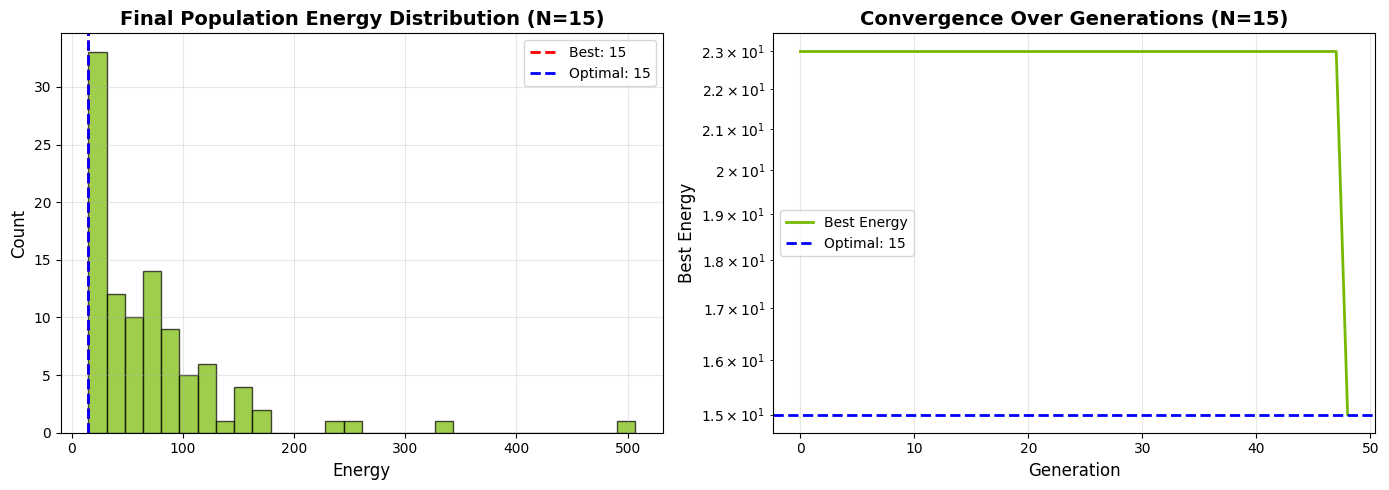


FINAL POPULATION STATISTICS
Best energy:         15
Optimal energy:      15
Optimality gap:      0.00%
Mean energy:         74.32
Std energy:          69.28
Worst energy:        507
Population size:     100
Generations:         48
Function evals:      148
Best sequence:       [-1 -1 -1 -1 -1  1  1 -1 -1  1  1 -1  1 -1  1]

[2] Running Correctness Verification...

EXPERIMENT 1: CORRECTNESS VERIFICATION

--- Testing N=5 ---
N=5: Initial best energy = 2.0 (optimal: 2)


MTS N=5:   0%|          | 0/200 [00:00<?, ?it/s]



✓ Target energy 2 reached at generation 1

Final best energy: 2.0
Optimality gap: 0.00%
Function evaluations: 50
✓ Local minimum check: PASS

--- Testing N=7 ---
N=7: Initial best energy = 3.0 (optimal: 3)


MTS N=7:   0%|          | 0/200 [00:00<?, ?it/s]



✓ Target energy 3 reached at generation 1

Final best energy: 3.0
Optimality gap: 0.00%
Function evaluations: 50
✓ Local minimum check: PASS

--- Testing N=10 ---
N=10: Initial best energy = 13.0 (optimal: 13)


MTS N=10:   0%|          | 0/200 [00:00<?, ?it/s]



✓ Target energy 13 reached at generation 1

Final best energy: 13.0
Optimality gap: 0.00%
Function evaluations: 50
✓ Local minimum check: PASS

--- Testing N=12 ---
N=12: Initial best energy = 18.0 (optimal: 10)


MTS N=12:   2%|▏         | 3/200 [00:00<00:05, 37.60it/s, Best_E=10]


✓ Target energy 10 reached at generation 4

Final best energy: 10.0
Optimality gap: 0.00%
Function evaluations: 53
✓ Local minimum check: PASS

[3] Running Optimality Gap Analysis...

EXPERIMENT 2: OPTIMALITY GAP ANALYSIS

--- Testing N=10 (3 trials) ---
Optimality Gap: 0.00% ± 0.00%
  Min: 0.00%, Max: 0.00%

--- Testing N=12 (3 trials) ---


Optimality Gap: 0.00% ± 0.00%
  Min: 0.00%, Max: 0.00%

--- Testing N=15 (3 trials) ---
Optimality Gap: 0.00% ± 0.00%
  Min: 0.00%, Max: 0.00%

--- Testing N=18 (3 trials) ---
Optimality Gap: 0.00% ± 0.00%
  Min: 0.00%, Max: 0.00%

--- Testing N=20 (3 trials) ---
Optimality Gap: 10.26% ± 14.50%
  Min: 0.00%, Max: 30.77%

OPTIMALITY GAP SUMMARY TABLE
   N |  Mean Gap (%) |  Std (%) |  Min (%) |  Max (%)
------------------------------------------------------------
  10 |          0.00 |     0.00 |     0.00 |     0.00
  12 |          0.00 |     0.00 |     0.00 |     0.00
  15 |          0.00 |     0.00 |     0.00 |     0.00
  18 |          0.00 |     0.00 |     0.00 |     0.00
  20 |         10.26 |    14.50 |     0.00 |    30.77

[4] Generating Scaling Analysis Plot...
Running N=10...
Running N=12...
Running N=15...
Running N=18...
Running N=20...
Running N=22...
Running N=24...


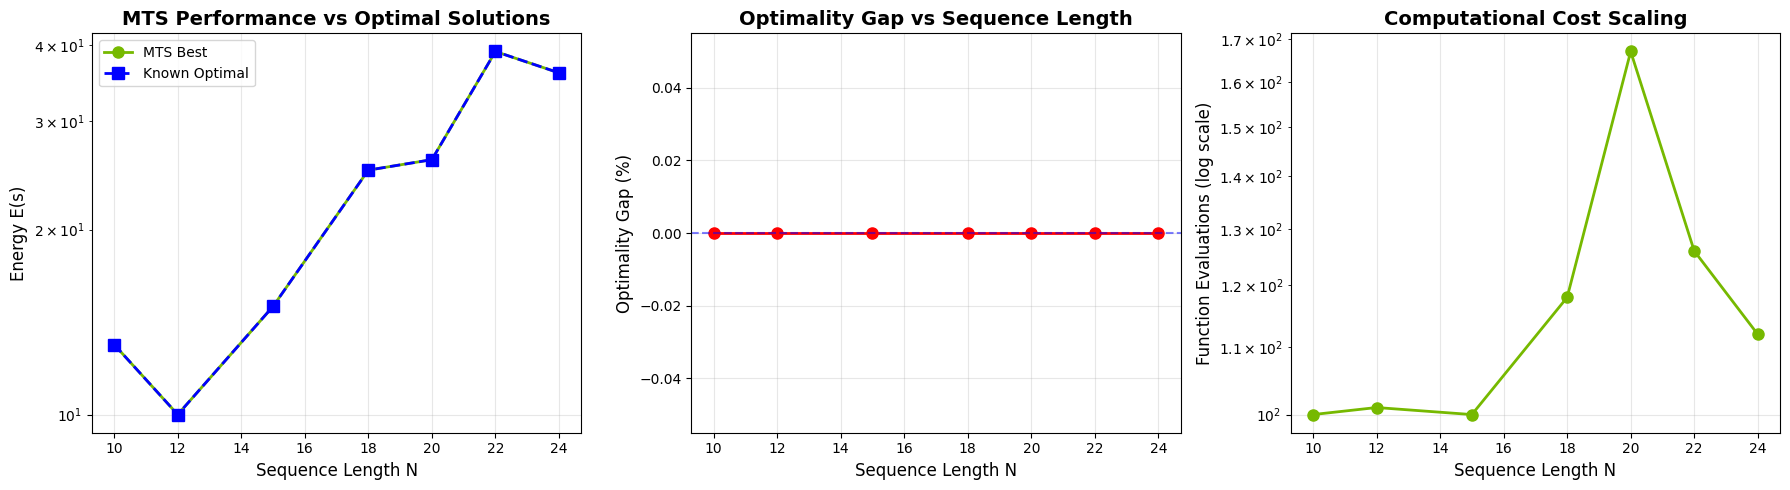


ALL EXPERIMENTS COMPLETED


In [7]:
"""
Memetic Tabu Search (MTS) for Low-Autocorrelation Binary Sequences (LABS)

Implementation based on:
[1] A. Gomez Cadavid et al., "Scaling advantage with quantum-enhanced memetic
    tabu search for LABS," arXiv:2511.04553v1, November 2025.
[2] T. Packebusch and S. Mertens, "Low autocorrelation binary sequences", Journal of Physics A: Mathematical and Theoretical, vol. 49, p. 165001,arXiv:1512.02475v2

Author: AutoQurelation Team at iQuHack 2026, using ChatGPT
Date: January 31, 2026
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import random
from dataclasses import dataclass
from tqdm import tqdm


# ============================================
# LABS Optimal Energies Database
# ============================================

# Source: T. Packebusch and S. Mertens (2016), arXiv:1512.02475v2
LABS_OPTIMAL = {
    2: 1, 3: 1, 4: 2, 5: 2, 6: 7, 7: 3, 8: 8, 9: 12, 10: 13,
    11: 5, 12: 10, 13: 6, 14: 19, 15: 15, 16: 24, 17: 32, 18: 25, 19: 29, 20: 26,
    21: 26, 22: 39, 23: 47, 24: 36, 25: 36, 26: 45, 27: 37, 28: 50, 29: 62, 30: 59,
    31: 67, 32: 64, 33: 64, 34: 65, 35: 73, 36: 82, 37: 86, 38: 87, 39: 99, 40: 108,
    41: 108, 42: 101, 43: 109, 44: 122, 45: 118, 46: 131, 47: 135, 48: 140, 49: 136, 50: 153,
    51: 153, 52: 166, 53: 170, 54: 175, 55: 171, 56: 192, 57: 188, 58: 197, 59: 205, 60: 218,
    61: 226, 62: 235, 63: 207, 64: 208, 65: 240, 66: 257
}


# ============================================
# Core LABS Energy Calculation
# ============================================

def calculate_energy(s: np.ndarray) -> float:
    """
    Calculate LABS objective function: E(s) = sum_{k=1}^{N-1} C_k^2
    where C_k = sum_{i=1}^{N-k} s_i * s_{i+k}

    Args:
        s: Binary sequence of ±1 values, shape (N,)

    Returns:
        Energy E(s) as float

    Time Complexity: O(N²)
    """
    N = len(s)
    energy = 0.0

    for k in range(1, N):
        C_k = 0.0
        for i in range(N - k):
            C_k += s[i] * s[i + k]
        energy += C_k * C_k

    return energy


def calculate_energy_vectorized(s: np.ndarray) -> float:
    """
    Vectorized LABS energy calculation (faster for large N).

    Args:
        s: Binary sequence of ±1 values

    Returns:
        Energy E(s)
    """
    N = len(s)
    energy = 0.0

    for k in range(1, N):
        C_k = np.sum(s[:N-k] * s[k:])
        energy += C_k * C_k

    return energy


# ============================================
# Genetic Operators (Algorithm 3)
# ============================================

def combine(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    Single-point crossover between two parent sequences.

    Algorithm: Choose cut point k uniformly from {1, ..., N-1},
               return p1[1:k] || p2[k+1:N]

    Args:
        p1: Parent 1 sequence
        p2: Parent 2 sequence

    Returns:
        Child sequence

    Reference: Algorithm 3 in [1]
    """
    N = len(p1)
    k = random.randint(1, N - 1)  # Cut point in {1, ..., N-1}
    child = np.concatenate([p1[:k], p2[k:]])
    return child


def mutate(s: np.ndarray, p_mut: float) -> np.ndarray:
    """
    Stochastic bit-flip mutation.

    Algorithm: For each position i, flip bit with probability p_mut

    Args:
        s: Sequence to mutate
        p_mut: Mutation probability per bit

    Returns:
        Mutated sequence

    Reference: Algorithm 3 in [1]
    """
    s_mut = s.copy()
    N = len(s)

    for i in range(N):
        if random.random() < p_mut:
            s_mut[i] *= -1  # Flip bit

    return s_mut


def flip(s: np.ndarray, i: int) -> np.ndarray:
    """
    Flip bit at position i.

    Args:
        s: Original sequence
        i: Position to flip

    Returns:
        Sequence with bit i flipped
    """
    s_flip = s.copy()
    s_flip[i] *= -1
    return s_flip


# ============================================
# Tabu Search (Algorithm 2 & Appendix F)
# ============================================

def tabu_search(s0: np.ndarray, max_iter: int = None, verbose: bool = False) -> np.ndarray:
    """
    Tabu search with randomized tenure and aspiration criterion.

    Key Features:
    - Short-term memory (tabu list) prevents cycling
    - Randomized tenure between M/10 and M/2
    - Aspiration criterion allows tabu moves if they improve global best
    - Random iteration budget M ∈ [N/10, 3N/2]

    Args:
        s0: Starting sequence
        max_iter: Maximum iterations (default: random between N/10 and 3N/2)
        verbose: Print progress

    Returns:
        Locally improved sequence

    Reference: Algorithm 2 and Appendix F in [1]
    """
    N = len(s0)
    s = s0.copy()
    s_best = s.copy()
    E_best = calculate_energy_vectorized(s_best)

    # Initialize tabu list (stores iteration when each position becomes tabu)
    tabu_list = np.zeros(N, dtype=int)

    # Random budget for iterations
    if max_iter is None:
        M = random.randint(max(1, N // 10), max(2, 3 * N // 2))
    else:
        M = max_iter

    for t in range(1, M + 1):
        best_neighbor = None
        best_neighbor_energy = float('inf')
        best_i = -1

        # Explore 1-flip neighborhood
        for i in range(N):
            s_neighbor = flip(s, i)
            E_neighbor = calculate_energy_vectorized(s_neighbor)

            # Check if move is tabu
            is_tabu = tabu_list[i] > t

            if is_tabu:
                # Aspiration criterion: allow if it improves global best
                if E_neighbor < E_best:
                    best_neighbor = s_neighbor
                    best_neighbor_energy = E_neighbor
                    best_i = i
            else:
                # Non-tabu move: accept if best in neighborhood
                if E_neighbor < best_neighbor_energy:
                    best_neighbor = s_neighbor
                    best_neighbor_energy = E_neighbor
                    best_i = i

        # Move to best neighbor
        if best_neighbor is not None:
            s = best_neighbor

            # Set tabu tenure (randomized between M/10 and M/2)
            tenure = random.randint(max(1, M // 10), max(2, M // 2))
            tabu_list[best_i] = t + tenure

            # Update global best if improved
            if best_neighbor_energy < E_best:
                s_best = best_neighbor.copy()
                E_best = best_neighbor_energy
                if verbose:
                    print(f"  Tabu iter {t}: New best E={E_best}")

    return s_best


# ============================================
# Memetic Tabu Search (Algorithm 1)
# ============================================

@dataclass
class MTSResult:
    """Container for MTS results."""
    best_sequence: np.ndarray
    best_energy: float
    final_population: List[np.ndarray]
    energy_history: List[float]
    generation_count: int
    function_evaluations: int
    optimal_energy: float = None
    optimality_gap: float = None


def memetic_tabu_search(
    N: int,
    K: int = 100,
    p_comb: float = 0.9,
    p_mut: float = None,
    G_max: int = 1000,
    E_target: float = None,
    verbose: bool = True,
    use_optimal_target: bool = True
) -> MTSResult:
    """
    Memetic Tabu Search for LABS problem.

    Args:
        N: Sequence length
        K: Population size (default: 100)
        p_comb: Recombination probability (default: 0.9)
        p_mut: Mutation probability (default: 1/N)
        G_max: Maximum number of generations (default: 1000)
        E_target: Target energy to stop (optional, auto-set from optimal database)
        verbose: Print progress
        use_optimal_target: Automatically set E_target from optimal database

    Returns:
        MTSResult containing best sequence, energy, and convergence data

    Reference: Algorithm 1 in [1]
    """
    if p_mut is None:
        p_mut = 1.0 / N

    # Set target from optimal database if available
    if use_optimal_target and N in LABS_OPTIMAL and E_target is None:
        E_target = LABS_OPTIMAL[N]

    # Initialize population randomly
    population = [np.random.choice([-1, 1], size=N) for _ in range(K)]

    # Find initial best
    s_best = population[0].copy()
    E_best = calculate_energy_vectorized(s_best)

    for individual in population[1:]:
        E = calculate_energy_vectorized(individual)
        if E < E_best:
            s_best = individual.copy()
            E_best = E

    energy_history = [E_best]
    function_evaluations = K  # Initial population evaluation

    if verbose:
        opt_str = f" (optimal: {E_target})" if E_target is not None else ""
        print(f"N={N}: Initial best energy = {E_best}{opt_str}")

    # Main MTS loop
    progress_bar = tqdm(range(1, G_max + 1), desc=f"MTS N={N}", disable=not verbose)

    for G in progress_bar:
        # Check termination
        if E_target is not None and E_best <= E_target:
            if verbose:
                print(f"\n✓ Target energy {E_target} reached at generation {G}")
            break

        # Make child
        if random.random() < p_comb:
            # Tournament selection (size 2)
            p1 = random.choice(population)
            p2 = random.choice(population)
            child = combine(p1, p2)
        else:
            # Sample directly from population
            child = random.choice(population).copy()

        # Mutate child
        child = mutate(child, p_mut)

        # Tabu search with child
        child = tabu_search(child, verbose=False)
        E_child = calculate_energy_vectorized(child)
        function_evaluations += 1  # Count tabu search as one evaluation

        # Update best solution
        if E_child < E_best:
            s_best = child.copy()
            E_best = E_child
            if verbose:
                progress_bar.set_postfix({'Best_E': E_best})

        # Replace random individual in population
        replace_idx = random.randint(0, K - 1)
        population[replace_idx] = child

        energy_history.append(E_best)

    # Calculate optimality gap if optimal energy is known
    optimal_energy = LABS_OPTIMAL.get(N, None)
    optimality_gap = None
    if optimal_energy is not None:
        optimality_gap = (E_best - optimal_energy) / optimal_energy * 100.0

    if verbose:
        print(f"\nFinal best energy: {E_best}")
        if optimality_gap is not None:
            print(f"Optimality gap: {optimality_gap:.2f}%")
        print(f"Function evaluations: {function_evaluations}")

    return MTSResult(
        best_sequence=s_best,
        best_energy=E_best,
        final_population=population,
        energy_history=energy_history,
        generation_count=len(energy_history) - 1,
        function_evaluations=function_evaluations,
        optimal_energy=optimal_energy,
        optimality_gap=optimality_gap
    )


# ============================================
# Visualization Functions
# ============================================

def visualize_results(result: MTSResult, title_suffix: str = ""):
    """
    Visualize MTS results with two plots:
    1. Energy distribution of final population
    2. Best energy convergence over generations

    Args:
        result: MTSResult object
        title_suffix: Additional text for plot titles
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Energy distribution of final population
    energies = [calculate_energy_vectorized(individual) for individual in result.final_population]

    axes[0].hist(energies, bins=30, color='#76b900', alpha=0.7, edgecolor='black')
    axes[0].axvline(result.best_energy, color='red', linestyle='--', linewidth=2,
                    label=f'Best: {result.best_energy:.0f}')

    if result.optimal_energy is not None:
        axes[0].axvline(result.optimal_energy, color='blue', linestyle='--', linewidth=2,
                       label=f'Optimal: {result.optimal_energy}')

    axes[0].set_xlabel('Energy', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title(f'Final Population Energy Distribution{title_suffix}',
                     fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Best energy over generations
    axes[1].plot(result.energy_history, color='#76b900', linewidth=2, label='Best Energy')

    if result.optimal_energy is not None:
        axes[1].axhline(result.optimal_energy, color='blue', linestyle='--', linewidth=2,
                       label=f'Optimal: {result.optimal_energy}')

    axes[1].set_xlabel('Generation', fontsize=12)
    axes[1].set_ylabel('Best Energy', fontsize=12)
    axes[1].set_title(f'Convergence Over Generations{title_suffix}',
                     fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*60)
    print("FINAL POPULATION STATISTICS")
    print("="*60)
    print(f"Best energy:         {result.best_energy:.0f}")
    if result.optimal_energy is not None:
        print(f"Optimal energy:      {result.optimal_energy}")
        print(f"Optimality gap:      {result.optimality_gap:.2f}%")
    print(f"Mean energy:         {np.mean(energies):.2f}")
    print(f"Std energy:          {np.std(energies):.2f}")
    print(f"Worst energy:        {max(energies):.0f}")
    print(f"Population size:     {len(result.final_population)}")
    print(f"Generations:         {result.generation_count}")
    print(f"Function evals:      {result.function_evaluations}")
    print(f"Best sequence:       {result.best_sequence}")
    print("="*60)


def visualize_scaling_analysis(results: List[MTSResult]):
    """
    Visualize scaling analysis across multiple N values.

    Args:
        results: List of MTSResult objects for different N
    """
    N_values = [len(r.best_sequence) for r in results]
    best_energies = [r.best_energy for r in results]
    optimal_energies = [r.optimal_energy if r.optimal_energy is not None else np.nan
                       for r in results]
    gaps = [r.optimality_gap if r.optimality_gap is not None else np.nan
           for r in results]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Best vs Optimal Energy
    axes[0].plot(N_values, best_energies, 'o-', color='#76b900', linewidth=2,
                markersize=8, label='MTS Best')
    axes[0].plot(N_values, optimal_energies, 's--', color='blue', linewidth=2,
                markersize=8, label='Known Optimal')
    axes[0].set_xlabel('Sequence Length N', fontsize=12)
    axes[0].set_ylabel('Energy E(s)', fontsize=12)
    axes[0].set_title('MTS Performance vs Optimal Solutions', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_yscale('log')

    # Plot 2: Optimality Gap
    valid_gaps = [(n, g) for n, g in zip(N_values, gaps) if not np.isnan(g)]
    if valid_gaps:
        n_vals, g_vals = zip(*valid_gaps)
        axes[1].plot(n_vals, g_vals, 'o-', color='red', linewidth=2, markersize=8)
        axes[1].axhline(0, color='blue', linestyle='--', alpha=0.5)
        axes[1].set_xlabel('Sequence Length N', fontsize=12)
        axes[1].set_ylabel('Optimality Gap (%)', fontsize=12)
        axes[1].set_title('Optimality Gap vs Sequence Length', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3)

    # Plot 3: Function Evaluations
    func_evals = [r.function_evaluations for r in results]
    axes[2].semilogy(N_values, func_evals, 'o-', color='#76b900', linewidth=2, markersize=8)
    axes[2].set_xlabel('Sequence Length N', fontsize=12)
    axes[2].set_ylabel('Function Evaluations (log scale)', fontsize=12)
    axes[2].set_title('Computational Cost Scaling', fontsize=14, fontweight='bold')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# ============================================
# Validation Experiments
# ============================================

def experiment_correctness_verification(N_range: List[int] = [5, 7, 10, 12, 15]):
    """
    Experiment 1: Correctness verification on small sequences.

    Args:
        N_range: List of sequence lengths to test
    """
    print("\n" + "="*60)
    print("EXPERIMENT 1: CORRECTNESS VERIFICATION")
    print("="*60)

    results = []

    for N in N_range:
        print(f"\n--- Testing N={N} ---")
        result = memetic_tabu_search(
            N=N,
            K=50,
            G_max=200,
            verbose=True
        )
        results.append(result)

        # Verify local minimum property
        s = result.best_sequence
        E_s = result.best_energy
        is_local_min = True

        for i in range(N):
            s_flip = flip(s, i)
            E_flip = calculate_energy_vectorized(s_flip)
            if E_flip < E_s:
                is_local_min = False
                break

        print(f"✓ Local minimum check: {'PASS' if is_local_min else 'FAIL'}")

    return results


def experiment_optimality_gap_analysis(N_range: List[int] = [10, 12, 15, 18, 20, 24, 27, 30],
                                      trials: int = 5):
    """
    Experiment 2: Optimality gap analysis across multiple trials.

    Args:
        N_range: List of sequence lengths to test
        trials: Number of independent trials per N
    """
    print("\n" + "="*60)
    print("EXPERIMENT 2: OPTIMALITY GAP ANALYSIS")
    print("="*60)

    gap_data = {}

    for N in N_range:
        print(f"\n--- Testing N={N} ({trials} trials) ---")
        gaps = []

        for trial in range(trials):
            result = memetic_tabu_search(
                N=N,
                K=100,
                G_max=500,
                verbose=False
            )

            if result.optimality_gap is not None:
                gaps.append(result.optimality_gap)

        gap_data[N] = {
            'mean': np.mean(gaps),
            'std': np.std(gaps),
            'min': np.min(gaps),
            'max': np.max(gaps),
            'median': np.median(gaps)
        }

        print(f"Optimality Gap: {gap_data[N]['mean']:.2f}% ± {gap_data[N]['std']:.2f}%")
        print(f"  Min: {gap_data[N]['min']:.2f}%, Max: {gap_data[N]['max']:.2f}%")

    # Summary table
    print("\n" + "="*60)
    print("OPTIMALITY GAP SUMMARY TABLE")
    print("="*60)
    print(f"{'N':>4} | {'Mean Gap (%)':>13} | {'Std (%)':>8} | {'Min (%)':>8} | {'Max (%)':>8}")
    print("-" * 60)
    for N in N_range:
        data = gap_data[N]
        print(f"{N:>4} | {data['mean']:>13.2f} | {data['std']:>8.2f} | "
              f"{data['min']:>8.2f} | {data['max']:>8.2f}")

    return gap_data


def run_single_example(N: int = 15):
    """
    Run a single MTS example with visualization.

    Args:
        N: Sequence length
    """
    print("="*60)
    print(f"MEMETIC TABU SEARCH FOR LABS (N={N})")
    print("="*60)

    # Run MTS
    result = memetic_tabu_search(
        N=N,
        K=100,
        p_comb=0.9,
        p_mut=None,  # Default 1/N
        G_max=500,
        verbose=True
    )

    # Visualize
    visualize_results(result, title_suffix=f" (N={N})")

    return result


# ============================================
# Main Execution
# ============================================

if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    random.seed(42)

    print("\n" + "="*60)
    print("MEMETIC TABU SEARCH (MTS) FOR LABS")
    print("Implementation based on Gomez Cadavid et al. (2025) and Packebusch and Mertens (2016)")
    print("="*60)

    # Example 1: Single run with visualization
    print("\n[1] Single Example Run")
    result = run_single_example(N=15)

    # Example 2: Correctness verification
    print("\n[2] Running Correctness Verification...")
    correctness_results = experiment_correctness_verification([5, 7, 10, 12])

    # Example 3: Optimality gap analysis
    print("\n[3] Running Optimality Gap Analysis...")
    gap_data = experiment_optimality_gap_analysis([10, 12, 15, 18, 20], trials=3)

    # Example 4: Scaling visualization
    print("\n[4] Generating Scaling Analysis Plot...")
    scaling_N = [10, 12, 15, 18, 20, 22, 24]
    scaling_results = []
    for N in scaling_N:
        print(f"Running N={N}...")
        res = memetic_tabu_search(N=N, K=100, G_max=500, verbose=False)
        scaling_results.append(res)

    visualize_scaling_analysis(scaling_results)

    print("\n" + "="*60)
    print("ALL EXPERIMENTS COMPLETED")
    print("="*60)

## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem.

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem.

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction.

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [3]:
import math
import cudaq

# ============================================================
# Primitive RZZ kernel
# ============================================================
# madeup values
@cudaq.kernel
def rzz_gate():
    """RZZ(theta) via CNOT-RZ-CNOT."""
    qv = cudaq.qvector(2)
    cx(qv[0], qv[1])
    rz(np.pi, qv[1])
    cx(qv[0], qv[1])


# Draw the circuit
print(cudaq.draw(rzz_gate))

                            
q0 : ──●─────────────────●──
     ╭─┴─╮╭───────────╮╭─┴─╮
q1 : ┤ x ├┤ rz(3.142) ├┤ x ├
     ╰───╯╰───────────╯╰───╯



In [5]:
@cudaq.kernel
def rzz_gate(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    """RZZ(theta) via CNOT-RZ-CNOT."""
    cx(q0, q1)
    rz(theta, q1)
    cx(q0, q1)

# these are madeup values to draw the circuit.
@cudaq.kernel
def two_qubit_block():
    """
    2-qubit DCQO block, Code-2 / Fig. 3 style.
    Acts on 2 qubits initialised to |00>.
    """
    q = cudaq.qvector(2)
    s = math.pi / 2.0

    # Optional: start from |++> instead of |00>
    #h(q[0])
    #h(q[1])

    # Code-2 style sequence using Rx and RZZ
    rx(s,  q[1])
    rzz_gate(q[0], q[1], np.pi)
    rx(s,  q[0])
    rx(-s, q[1])
    rzz_gate(q[0], q[1], np.pi)
    rx(-s, q[0])

    #mz(q)

# Draw the circuit
print(cudaq.draw(two_qubit_block))

                                         ╭───────────╮                        »
q0 : ───────────────●─────────────────●──┤ rx(1.571) ├───●─────────────────●──»
     ╭───────────╮╭─┴─╮╭───────────╮╭─┴─╮├───────────┴╮╭─┴─╮╭───────────╮╭─┴─╮»
q1 : ┤ rx(1.571) ├┤ x ├┤ rz(3.142) ├┤ x ├┤ rx(-1.571) ├┤ x ├┤ rz(3.142) ├┤ x ├»
     ╰───────────╯╰───╯╰───────────╯╰───╯╰────────────╯╰───╯╰───────────╯╰───╯»

################################################################################

╭────────────╮
┤ rx(-1.571) ├
╰────────────╯
──────────────
              



In [7]:
# ============================================================
# Four-qubit block (Code-2 style) as a kernel
# ============================================================
# these are made up values.
@cudaq.kernel
def four_qubit_block():
    """
    4-qubit DCQO block, Code-2 / Fig. 4 style.
    Acts on 4 qubits initialised to |0000>.
    """
    q = cudaq.qvector(4)
    s  = math.pi / 2.0
    pi = math.pi

    # Optional: start from |++++>
    #for i in range(4):
    #    h(q[i])

    # Left edge single-qubit gates
    rx(-s, q[0])   # Rx†(π/2)
    ry( s, q[1])   # Ry(π/2)
    ry(-s, q[2])   # Ry†(π/2)

    # Rzz†(π/2) on (q0,q1) and (q2,q3)
    rzz_gate(q[0], q[1], -s)
    rzz_gate(q[2], q[3], -s)

    # Next single-qubit layer
    rx( s,  q[0])  # Rx(π/2)
    ry(-s,  q[1])  # Ry†(π/2)
    ry( s,  q[2])  # Ry(π/2)
    rx(-s,  q[3])  # Rx†(π/2)

    # Rx†(π/2) on q1, q2
    rx(-s, q[1])
    rx(-s, q[2])

    # Rzz(theta) between q1-q2
    rzz_gate(q[1], q[2], np.pi)

    # q1: Rx(π/2), Ry(π/2); q2: Rx(π)
    rx(s,  q[1])
    rx(pi, q[2])
    ry(s,  q[1])

    # Rzz(π/2) between q0-q1
    rzz_gate(q[0], q[1], s)

    # q0: Rx(π/2), q1: Ry†(π/2)
    rx(s,  q[0])
    ry(-s, q[1])

    # Rzz†(theta) between q1-q2
    rzz_gate(q[1], q[2], -np.pi)

    # q1: Rx(π/2); q2: Rx†(π)
    rx(s,   q[1])
    rx(-pi, q[2])

    # Rzz†(theta) between q1-q2
    rzz_gate(q[1], q[2], -np.pi)

    # q1: Rx†(π); q2: Ry(π/2)
    rx(-pi, q[1])
    ry( s,  q[2])

    # Rzz†(π/2) between q2-q3
    rzz_gate(q[2], q[3], -s)

    # q2: Ry†(π/2), Rx†(π/2); q3: Rx†(π/2)
    ry(-s, q[2])
    rx(-s, q[2])
    rx(-s, q[3])

    # Rzz(theta) between q1-q2
    rzz_gate(q[1], q[2], np.pi)

    # Pre-final single-qubit gates
    rx( s, q[1])
    ry(-s, q[1])
    rx( s, q[2])
    ry( s, q[2])

    # Final Rzz(π/2) on (q0,q1) and (q2,q3)
    rzz_gate(q[0], q[1], s)
    rzz_gate(q[2], q[3], s)

    # Final single-qubit gates
    ry( s, q[1])
    ry(-s, q[2])
    rx( s, q[3])

    #mz(q)

# Draw the circuit
print(cudaq.draw(four_qubit_block))

     ╭────────────╮                        ╭───────────╮                    »
q0 : ┤ rx(-1.571) ├──●──────────────────●──┤ rx(1.571) ├────────────────────»
     ├───────────┬╯╭─┴─╮╭────────────╮╭─┴─╮├───────────┴╮╭────────────╮     »
q1 : ┤ ry(1.571) ├─┤ x ├┤ rz(-1.571) ├┤ x ├┤ ry(-1.571) ├┤ rx(-1.571) ├──●──»
     ├───────────┴╮╰───╯╰────────────╯╰───╯├───────────┬╯├────────────┤╭─┴─╮»
q2 : ┤ ry(-1.571) ├──●──────────────────●──┤ ry(1.571) ├─┤ rx(-1.571) ├┤ x ├»
     ╰────────────╯╭─┴─╮╭────────────╮╭─┴─╮├───────────┴╮╰────────────╯╰───╯»
q3 : ──────────────┤ x ├┤ rz(-1.571) ├┤ x ├┤ rx(-1.571) ├───────────────────»
                   ╰───╯╰────────────╯╰───╯╰────────────╯                   »

################################################################################

                                                                   »
──────────────────────────────────────────────●─────────────────●──»
                  ╭───────────╮╭───────────╮╭─┴─╮╭───────────╮╭─┴─╮»
────────

## Puting Everything Together

In [8]:
import math
import cudaq

# ============================================================
# Primitive RZZ kernel
# ============================================================
@cudaq.kernel
def rzz_gate(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    """RZZ(theta) via CNOT-RZ-CNOT."""
    cx(q0, q1)
    rz(theta, q1)
    cx(q0, q1)
# ============================================================
# Two-qubit block (Code-2 style) as a kernel
# ============================================================

@cudaq.kernel
def two_qubit_block(theta: float):
    """
    2-qubit DCQO block, Code-2 / Fig. 3 style.
    Acts on 2 qubits initialised to |00>.
    """
    q = cudaq.qvector(2)
    s = math.pi / 2.0

    # Optional: start from |++> instead of |00>
    #h(q[0])
    #h(q[1])

    # Code-2 style sequence using Rx and RZZ
    rx(s,  q[1])
    rzz_gate(q[0], q[1], theta)
    rx(s,  q[0])
    rx(-s, q[1])
    rzz_gate(q[0], q[1], theta)
    rx(-s, q[0])

    mz(q)


# ============================================================
# Four-qubit block (Code-2 style) as a kernel
# ============================================================

@cudaq.kernel
def four_qubit_block(theta: float):
    """
    4-qubit DCQO block, Code-2 / Fig. 4 style.
    Acts on 4 qubits initialised to |0000>.
    """
    q = cudaq.qvector(4)
    s  = math.pi / 2.0
    pi = math.pi

    # Optional: start from |++++>
    #for i in range(4):
    #    h(q[i])

    # Left edge single-qubit gates
    rx(-s, q[0])   # Rx†(π/2)
    ry( s, q[1])   # Ry(π/2)
    ry(-s, q[2])   # Ry†(π/2)

    # Rzz†(π/2) on (q0,q1) and (q2,q3)
    rzz_gate(q[0], q[1], -s)
    rzz_gate(q[2], q[3], -s)

    # Next single-qubit layer
    rx( s,  q[0])  # Rx(π/2)
    ry(-s,  q[1])  # Ry†(π/2)
    ry( s,  q[2])  # Ry(π/2)
    rx(-s,  q[3])  # Rx†(π/2)

    # Rx†(π/2) on q1, q2
    rx(-s, q[1])
    rx(-s, q[2])

    # Rzz(theta) between q1-q2
    rzz_gate(q[1], q[2], theta)

    # q1: Rx(π/2), Ry(π/2); q2: Rx(π)
    rx(s,  q[1])
    rx(pi, q[2])
    ry(s,  q[1])

    # Rzz(π/2) between q0-q1
    rzz_gate(q[0], q[1], s)

    # q0: Rx(π/2), q1: Ry†(π/2)
    rx(s,  q[0])
    ry(-s, q[1])

    # Rzz†(theta) between q1-q2
    rzz_gate(q[1], q[2], -theta)

    # q1: Rx(π/2); q2: Rx†(π)
    rx(s,   q[1])
    rx(-pi, q[2])

    # Rzz†(theta) between q1-q2
    rzz_gate(q[1], q[2], -theta)

    # q1: Rx†(π); q2: Ry(π/2)
    rx(-pi, q[1])
    ry( s,  q[2])

    # Rzz†(π/2) between q2-q3
    rzz_gate(q[2], q[3], -s)

    # q2: Ry†(π/2), Rx†(π/2); q3: Rx†(π/2)
    ry(-s, q[2])
    rx(-s, q[2])
    rx(-s, q[3])

    # Rzz(theta) between q1-q2
    rzz_gate(q[1], q[2], theta)

    # Pre-final single-qubit gates
    rx( s, q[1])
    ry(-s, q[1])
    rx( s, q[2])
    ry( s, q[2])

    # Final Rzz(π/2) on (q0,q1) and (q2,q3)
    rzz_gate(q[0], q[1], s)
    rzz_gate(q[2], q[3], s)

    # Final single-qubit gates
    ry( s, q[1])
    ry(-s, q[2])
    rx( s, q[3])

    mz(q)


# ============================================================
# Lightweight validation
# ============================================================

def validate_blocks():
    print("\n" + "="*60)
    print("EXERCISE 3 – DCQO BLOCKS (CODE-2 STYLE) VALIDATION")
    print("="*60)

    theta_2 = math.pi / 4.0
    theta_4 = math.pi / 8.0

    # Two-qubit block
    print("\n[1] Testing two-qubit block (Fig. 3 style)...")
    try:
        res2 = cudaq.sample(two_qubit_block, theta_2, shots_count=16)
        print(f"  ✓ Ran two-qubit block with θ={theta_2:.3f}")
        print(f"  ✓ Unique bitstrings: {len(res2)}")
    except Exception as e:
        print(f"  ✗ Two-qubit block failed: {e}")

    # Four-qubit block
    print("\n[2] Testing four-qubit block (Fig. 4 style)...")
    try:
        res4 = cudaq.sample(four_qubit_block, theta_4, shots_count=16)
        print(f"  ✓ Ran four-qubit block with θ={theta_4:.3f}")
        print(f"  ✓ Unique bitstrings: {len(res4)}")
    except Exception as e:
        print(f"  ✗ Four-qubit block failed: {e}")

    print("\n[3] Gate counts from paper (per block):")
    print("  Two-qubit:  2 RZZ  +  4 single-qubit rotations")
    print("  Four-qubit: 10 RZZ + 28 single-qubit rotations")
    print("="*60)

validate_blocks()


EXERCISE 3 – DCQO BLOCKS (CODE-2 STYLE) VALIDATION

[1] Testing two-qubit block (Fig. 3 style)...
  ✓ Ran two-qubit block with θ=0.785
  ✓ Unique bitstrings: 3

[2] Testing four-qubit block (Fig. 4 style)...
  ✓ Ran four-qubit block with θ=0.393
  ✓ Unique bitstrings: 5

[3] Gate counts from paper (per block):
  Two-qubit:  2 RZZ  +  4 single-qubit rotations
  Four-qubit: 10 RZZ + 28 single-qubit rotations


There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model.

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [10]:
def get_interactions(N):
    """
    Generates the interaction sets G2 and G4 based on the loop limits in Eq. 15.
    Returns standard 0-based indices as lists of lists of ints.

    Args:
        N (int): Sequence length.

    Returns:
        G2: List of lists containing two body term indices
        G4: List of lists containing four body term indices
    """

    #TODO - complete the loops below to compute G2 and G4 indicies


    return G2, G4



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [ ]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], steps: int, dt: float, T: float, thetas: list[float]):

    reg = cudaq.qvector(N)
    h(reg)

    # TODO - write the full kernel to apply the trotterized circuit




T=1               # total time
n_steps = 1       # number of trotter steps
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

thetas =[]

for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

# TODO - Sample your kernel to make sure it works

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



NameError: name 'G2' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



NameError: name 'G2' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
NameError: name 'G2' is not defined

During handling of the above exception, another exception occurred:

AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above e

## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


In [11]:
# TODO - write code here to sample from your CUDA-Q kernel and used the results to seed your MTS population

The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches.

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best.

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below.


<img src="images/quantum_enhanced_optimization_LABS/tabu_search_results.png" width="900">

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution.

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically.

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?